# **Autoencoders, GANs, and Diffusion Models**
Autoencoders are artificial neural networks capable of learning dense representations of the input data, called latent representations or codings, without any supervision (i.e., the training set is unlabeled). These codings typically have a much lower dimensionality than the input data, making autoencoders useful for dimensionality reduction (see Chapter 8), especially for visualization purposes. Autoencoders also act as feature detectors, and they can be used for unsupervised pretraining of deep neural networks (as we discussed in Chapter 11). Lastly, some autoencoders are generative models: they are capable of randomly generating new data that looks very similar to the training data. For example, you could train an autoencoder on pictures of faces, and it would then be able to generate new faces.

Generative adversarial networks (GANs) are also neural nets capable of generating data. In fact, they can generate pictures of faces so convincing that it is hard to believe the people they represent do not exist. You can judge so for yourself by visiting https://thispersondoesnotexist.com, a website that shows faces generated by a GAN architecture called StyleGAN. You can also check out https://thisrentaldoesnotexist.com to see some generated Airbnb listings. GANs are now widely used for super resolution (increasing the resolution of an image), colorization, powerful image editing (e.g., replacing photo bombers with realistic background), turning simple sketches into photorealistic images, predicting the next frames in a video, augmenting a dataset (to train other models), generating other types of data (such as text, audio, and time series), identifying the weaknesses in other models to strengthen them, and more.

A more recent addition to the generative learning party is diffusion models. In 2021, they managed to generate more diverse and higher-quality images than GANs, while also being much easier to train. However, diffusion models are much slower to run.

Autoencoders, GANs, and diffusion models are all unsupervised, they all learn latent representations, they can all be used as generative models, and they have man  similar applications. However, they work very differently:
- Autoencoders simply learn to copy their inputs to their outputs. This may sound like a trivial task, but as you will see, constraining the network in various ways can make it rather difficult. For example, you can limit the size of the latent representations, or you can add noise to the inputs and train the network to recover the original inputs. These constraints prevent the autoencoder from trivially copying the inputs directly to the outputs, which forces it to learn efficient ways of representing the data. In short, the codings are byproducts of the autoencoder learning the identity function under some constraints.

- GANs are composed of two neural networks: a generator that tries to generate data that looks similar to the training data, and a discriminator that tries to tell real data from fake data. This architecture is very original in deep learning in that the generator and the discriminator compete against each other during training: the generator is often compared to a criminal trying to make realistic counterfeit money, while the discriminator is like the police investigator trying to tell real money from fake. Adversarial training (training competing neural networks) is widely considered one of the most important innovations of the 2010s. In 2016, Yann LeCun even said that it was “the most interesting idea in the last 10 years in machine learning”.

- A denoising diffusion probabilistic model (DDPM) is trained to remove a tiny bit of noise from an image. If you then take an image entirely full of Gaussian noise and repeatedly run the diffusion model on that image, a high-quality image will gradually emerge, similar to the training images (but not identical).

In this chapter we will start by exploring in more depth how autoencoders work and how to use them for dimensionality reduction, feature extraction, unsupervised pretraining, or as generative models. This will naturally lead us to GANs. We will build a simple GAN to generate fake images, but we will see that training is often quite difficult. We will discuss the main difficulties you will encounter with adversarial training, as well as some of the main techniques to work around these difficulties. And lastly, we will build and train a DDPM and use it to generate images. Let’s start with autoencoders!

## **Efficient Data Representations**
Which of the following number sequences do you find the easiest to memorize?
- 40, 27, 25, 36, 81, 57, 10, 73, 19, 68
- 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14

At first glance, it would seem that the first sequence should be easier, since it is much shorter. However, if you look carefully at the second sequence, you will notice that it is just the list of even numbers from 50 down to 14. Once you notice this pattern, the second sequence becomes much easier to memorize than the first because you only need to remember the pattern (i.e., decreasing even numbers) and the starting and ending numbers (i.e., 50 and 14). Note that if you could quickly and easily memorize very long sequences, you would not care much about the existence of a pattern in the second sequence. You would just learn every number by heart, and that would be that. The fact that it is hard to memorize long sequences is what makes it useful to recognize patterns, and hopefully this clarifies why constraining an autoencoder during training pushes it to discover and exploit patterns in the data.

The relationship between memory, perception, and pattern matching was famously studied by [William Chase and Herbert Simon](https://homl.info/111) in the early 1970s. They observed that expert chess players were able to memorize the positions of all the pieces in a game by looking at the board for just five seconds, a task that most people would find impossible. However, this was only the case when the pieces were placed in realistic positions (from actual games), not when the pieces were placed randomly. Chess experts don’t have a much better memory than you and I; they just see chess patterns more easily, thanks to their experience with the game. Noticing patterns helps them store information efficiently.

Just like the chess players in this memory experiment, an autoencoder looks at the inputs, converts them to an efficient latent representation, and then spits out something that (hopefully) looks very close to the inputs. An autoencoder is always composed of two parts: an encoder (or recognition network) that converts the inputs to a latent representation, followed by a decoder (or generative network) that converts the internal representation to the outputs.

As you can see, an autoencoder typically has the same architecture as a multilayer perceptron (MLP; see Chapter 10), except that the number of neurons in the output layer must be equal to the number of inputs. In this example, there is just one hidden layer composed of two neurons (the encoder), and one output layer composed of three neurons (the decoder). The outputs are often called the reconstructions because the autoencoder tries to reconstruct the inputs. The cost function contains a reconstruction loss that penalizes the model when the reconstructions are different from the inputs.

Because the internal representation has a lower dimensionality than the input data (it is 2D instead of 3D), the autoencoder is said to be undercomplete. An undercomplete autoencoder cannot trivially copy its inputs to the codings, yet it must find a way to output a copy of its inputs. It is forced to learn the most important features in the input data (and drop the unimportant ones).

Let’s see how to implement a very simple undercomplete autoencoder for dimensionality reduction.

## **Performing PCA with an Undercomplete Linear Autoencoder**
If the autoencoder uses only linear activations and the cost function is the mean squared error (MSE), then it ends up performing principal component analysis (PCA; see Chapter 8).

The following code builds a simple linear autoencoder to perform PCA on a 3D dataset, projecting it to 2D:

In [5]:
import tensorflow as tf

encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss="mse", optimizer=optimizer)

2025-08-05 22:15:14.495180: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-05 22:15:14.579654: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-05 22:15:14.668570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754421314.801775    4820 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754421314.843459    4820 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754421315.058437    4820 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

This code is really not very different from all the MLPs we built in past chapters, but there are a few things to note:
- We organized the autoencoder into two subcomponents: the encoder and the decoder. Both are regular Sequential models with a single Dense layer each, and the autoencoder is a Sequential model containing the encoder followed by the decoder (remember that a model can be used as a layer in another model).

- The autoencoder’s number of outputs is equal to the number of inputs (i.e., 3). 

- To perform PCA, we do not use any activation function (i.e., all neurons are linear), and the cost function is the MSE. That’s because PCA is a linear transformation. We will see more complex and nonlinear autoencoders shortly.
  
Now let’s train the model on the same simple generated 3D dataset we used in Chapter 8 and use it to encode that dataset (i.e., project it to 2D):

In [6]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA

fashion_mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False)

x, y = fashion_mnist["data"], fashion_mnist["target"]
x_train, x_valid, x_test  = x[:30_000], x[30_000:60_000], x[60_000:]
y_train, y_valid, y_test  = y[:30_000], y[30_000:60_000], y[60_000:]

x_train = x_train / 255.0
x_valid = x_valid / 255.0
x_test = x_test / 255.0


pca = PCA(n_components=3, random_state=50)
x_train_3d = pca.fit_transform(x_train)
x_valid_3d = pca.fit_transform(x_valid)

In [6]:
history = autoencoder.fit(x_train_3d, x_train_3d, epochs=500, verbose=False)
codings = encoder.predict(x_train_3d)

I0000 00:00:1753727740.630720    5179 service.cc:152] XLA service 0x7fb68c016900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753727740.630755    5179 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce MX150, Compute Capability 6.1
2025-07-28 21:35:40.707591: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753727740.791425    5179 cuda_dnn.cc:529] Loaded cuDNN version 91100
2025-07-28 21:35:41.881251: W external/local_xla/xla/service/gpu/llvm_gpu_backend/default/nvptx_libdevice_path.cc:40] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  

KeyboardInterrupt: 

Note the ***x_train*** is used as both the inputs and targets.Here autoencoder try to find the best 2D plane to project the data onto, preserving as much variance in the data as it could(Just like PCA).

> #### **NOTE**
> You can think of an autoencoder as performing a form of self-supervised learning, since it is based on a supervised learning technique with automatically generated labels (in this case simply equal to the inputs).


## **Stacked Autoencoders**
Just like other neural networks we have discussed, autoencoders can have multiple hidden layers. In this case they are called stacked autoencoders (or deep autoencoders). Adding more layers helps the autoencoder learn more complex codings. That said, one must be careful not to make the autoencoder too powerful. Imagine an encoder so powerful that it just learns to map each input to a single arbitrary number (and the decoder learns the reverse mapping). Obviously such an autoencoder will reconstruct the training data perfectly, but it will not have learned any useful data representation in the process, and it is unlikely to generalize well to new instances.

The architecture of a stacked autoencoder is typically symmetrical with regard to the central hidden layer (the coding layer). To put it simply, it looks like a sandwich. For example, an autoencoder for Fashion MNIST (introduced in Chapter 10) may have 784 inputs, followed by a hidden layer with 100 neurons, then a central hidden layer of 30 neurons, then another hidden layer with 100 neurons, and an output layer with 784 neurons.

### **Implementing a Stacked Autoencoder Using Keras**
You can implement a stacked autoencoder very much like a regular deep MLP:

In [62]:
stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(100, activation="relu"), 
    tf.keras.layers.Dense(30, activation="relu")
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"), 
    tf.keras.layers.Dense(28 * 28)
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer="nadam")
history = stacked_ae.fit(x_train, x_train, epochs=20, 
                         validation_data=(x_valid, x_valid))

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0414 - val_loss: 0.0194
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0187 - val_loss: 0.0173
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0172 - val_loss: 0.0166
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0166 - val_loss: 0.0162
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0160 - val_loss: 0.0158
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0156 - val_loss: 0.0153
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0154 - val_loss: 0.0156
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0151 - val_loss: 0.0150
Epoch 9/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0149 - val_loss: 0.0147
Epoch 10/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0147 - val_loss: 0.0146
Epoch 11/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0145 - val_loss: 0.0146
Epoch 12/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

In [63]:
stacked_ae.save("stacked_autoencoder.keras")

Let’s go through this code:
- Just like earlier, we split the autoencoder model into two submodels: the encoder and the decoder.

- The encoder takes 28 × 28–pixel grayscale images, flattens them so that each image is represented as a vector of size 784, then processes these vectors through two Dense layers of diminishing sizes (100 units then 30 units), both using the ReLU activation function. For each input image, the encoder outputs a vector of size 30.

- The decoder takes codings of size 30 (output by the encoder) and processes them through two Dense layers of increasing sizes (100 units then 784 units), and it reshapes the final vectors into 28 × 28 arrays so the decoder’s outputs have the same shape as the encoder’s inputs.

- When compiling the stacked autoencoder, we use the MSE loss and Nadam optimization.

- Finally, we train the model using X_train as both the inputs and the targets. Similarly, we use X_valid as both the validation inputs and targets.

### **Visualizing the Reconstructions**
One way to ensure that an autoencoder is properly trained is to compare the inputs and the outputs: the differences should not be too significant. Let’s plot a few images from the validation set, as well as their reconstructions:

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_reconstructions(model, images, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    
    for image_index in range(n_images):
        ax = plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        ax.set_title("orig")
        ax.axis("off")
        
    for i in range(n_images):
        ax = plt.subplot(2, n_images, n_images + 1 + i)
        plt.imshow(reconstructions[i], cmap="binary")
        ax.set_title("recon")
        ax.axis("off")
        
    plt.tight_layout()
    plt.show()
    

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_reconstructions(model, images, n_images=5):
    input_shape = model.input_shape  

    origs = images[:n_images]
    
    if len(input_shape) == 2:
        batch = origs.reshape(n_images, -1)
    else:
        if origs.ndim == 2 or (origs.ndim == 3 and input_shape[-1] is not None and origs.shape[-1] == 784):
            batch = origs.reshape((n_images,) + tuple(input_shape[1:]))
        else:
            batch = origs
    
    preds = model.predict(batch)
    if preds.ndim == 2 and preds.shape[1] == 28*28:
        preds = preds.reshape(-1, 28, 28)
    if preds.ndim == 4 and preds.shape[-1] == 1:
        preds = preds.squeeze(-1)
    
    preds = np.clip(preds, 0, 1)
    

    fig = plt.figure(figsize=(n_images*1.5, 3))
    
    for i in range(n_images):
        ax = plt.subplot(2, n_images, i + 1)
        plt.imshow(origs[i].squeeze(), cmap="binary")
        ax.set_title("orig")
        ax.axis("off")
    
    for i in range(n_images):
        ax = plt.subplot(2, n_images, n_images + i + 1)
        plt.imshow(preds[i], cmap="binary")
        ax.set_title("recon")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


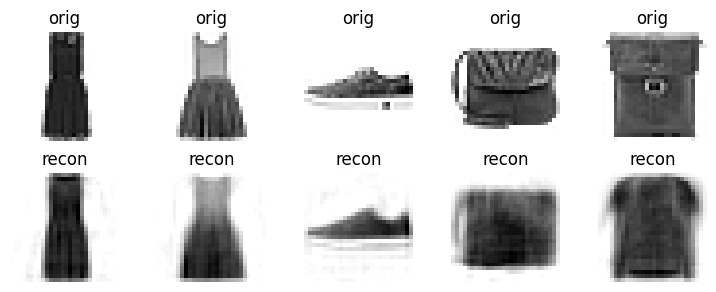

In [71]:
x_valid_flat = (x_valid.astype("float32"))  # shape (N,784)
# pass either the flat array or reshape to (N,28,28)—the function will flatten again:
images_for_plot = x_valid_flat.reshape(-1, 28, 28)
plot_reconstructions(stacked_ae, images_for_plot, n_images=5)


The reconstructions are recognizable, but a bit too lossy. We may need to train the model for longer, or make the encoder and decoder deeper, or make the codings larger. But if we make the network too powerful, it will manage to make perfect reconstructions without having learned any useful patterns in the data. For now, let’s go with this model.

### **Visualizing the Fashion MNIST Dataset**
Now that we have trained a stacked autoencoder, we can use it to reduce the dataset’s dimensionality. For visualization, this does not give great results compared to other dimensionality reduction algorithms (such as those we discussed in Chapter 8), but one big advantage of autoencoders is that they can handle large datasets with many instances and many features. So, one strategy is to use an autoencoder to reduce the dimensionality down to a reasonable level, then use another dimensionality reduction algorithm for visualization. Let’s use this strategy to visualize Fashion MNIST. First we’ll use the encoder from our stacked autoencoder to reduce the dimensionality down to 30, then we’ll use Scikit-Learn’s implementation of the t-SNE algorithm to reduce the dimensionality down to 2 for visualization:

In [9]:
from sklearn.manifold import TSNE

x_valid_compressed = stacked_encoder.predict(x_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=50)
x_valid_2D = tsne.fit_transform(x_valid_compressed)

NameError: name 'stacked_encoder' is not defined

Now we can plot the dataset:

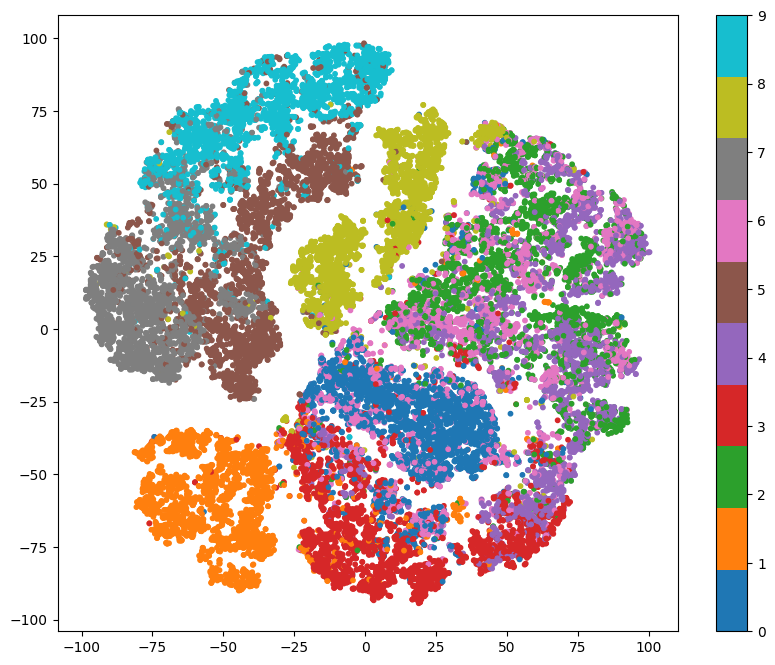

In [88]:
y_valid_int = y_valid.astype(int)
plt.figure(figsize=(10, 8))
plt.scatter(x_valid_2D[:, 0], x_valid_2D[:, 1], c=y_valid_int, s=10, 
            cmap="tab10")
plt.colorbar()
plt.show()

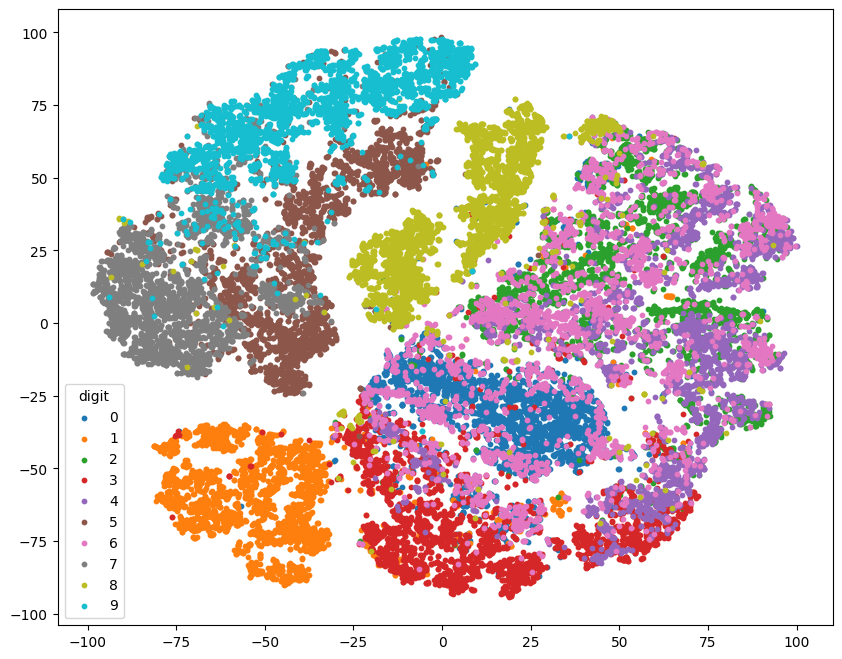

In [89]:
import numpy as np

unique_digits = np.unique(y_valid)   # array of strings: ['0','1',…,'9']

plt.figure(figsize=(10,8))
for d in unique_digits:
    mask = (y_valid == d)
    plt.scatter(
        x_valid_2D[mask, 0],
        x_valid_2D[mask, 1],
        s=10,
        label=d        # legend entry
    )
plt.legend(title="digit")
plt.show()


figures above shows the resulting scatterplot, beautified a bit by displaying some of the images. The t-SNE algorithm identified several clusters that match the classes reasonably well (each class is represented by a different color).

So, autoencoders can be used for dimensionality reduction. Another application is for unsupervised pretraining.

### **Unsupervised Pretraining Using Stacked Autoencoders**
As we discussed in Chapter 11, if you are tackling a complex supervised task but you do not have a lot of labeled training data, one solution is to find a neural network that performs a similar task and reuse its lower layers. This makes it possible to train a high-performance model using little training data because your neural network won’t have to learn all the lowlevel features; it will just reuse the feature detectors learned by the existing network.

Similarly, if you have a large dataset but most of it is unlabeled, you can first train a stacked autoencoder using all the data, then reuse the lower layers to create a neural network for your actual task and train it using the labeled data.

> #### **NOTE**
> Having plenty of unlabeled data and little labeled data is common. Building a large unlabeled dataset is often cheap (e.g., a simple script can download millions of images off the internet), but labeling those images (e.g., classifying them as cute or not) can usually be done reliably only by humans. Labeling instances is time-consuming and costly, so it’s normal to have only a few thousand human-labeled instances, or even less.

There is nothing special about the implementation: just train an autoencoder using all the training data (labeled plus unlabeled), then reuse its encoder layers to create a new neural network.

Next, let’s look at a few techniques for training stacked autoencoders.

### **Tying Weights**
When an autoencoder is neatly symmetrical, like the one we just built, a common technique is to tie the weights of the decoder layers to the weights of the encoder layers. This halves the number of weights in the model, speeding up training and limiting the risk of overfitting. Specifically, if the autoencoder has a total of N layers (not counting the input layer), and **W**<sub>*L*</sub> represents the connection weights of the **L**<sup>th</sup> layer (e.g., layer 1 is the first hidden layer, layer N/2 is the coding layer, and layer N is the output layer), then the decoder layer weights can be defined as **W**<sub>*L*</sub> = **W**<sub>*N-L+1*</sub> (with L = N / 2 + 1, …, N).

To tie weights between layers using keras, lete's define a custom layer:

In [10]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense_layer, activation=None, **kwargs):
        """
        dense_layer:  an existing tf.keras.layers.Dense instance whose weights
                      you want to tie (transpose) in this layer.
        activation:   name or callable activation for the transpose layer.
        """
        super().__init__(**kwargs)
        self.dense = dense_layer
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        # At build time, self.dense.kernel exists and has shape [fan_in, units].
        fan_in = int(self.dense.kernel.shape[0])
        # Create a bias for each of the fan_in outputs
        self.bias = self.add_weight(
            name="bias",
            shape=(fan_in,),
            initializer="zeros",
            trainable=True
        )
        super().build(input_shape)

    def call(self, inputs):
        # inputs: (batch, units) where units == self.dense.units
        # kernel: (fan_in, units)
        # matmul with transpose_b=True → (batch, fan_in)
        z = tf.matmul(inputs, self.dense.kernel, transpose_b=True)
        return self.activation(z + self.bias)

    def compute_output_shape(self, input_shape):
        # input_shape = (batch, units)
        fan_in = int(self.dense.kernel.shape[0])
        return (input_shape[0], fan_in)


This custom layer acts like a regular ***Dense*** layer, but it uses another Dense layer’s weights, transposed (setting transpose_b=True is equivalent to transposing the second argument, but it’s more efficient as it performs the transposition on the fly within the ***matmul()*** operation). However, it uses its own bias vector. Now we can build a new stacked autoencoder, much like the previous one but with the decoder’s Dense layers tied to the encoder’s ***Dense*** layers:

In [114]:
dense_1 = tf.keras.layers.Dense(100, activation="relu")
dense_2 = tf.keras.layers.Dense(30, activation="relu")

tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(), 
    dense_1, 
    dense_2
])

tied_decoder = tf.keras.Sequential([
    DenseTranspose(dense_2, activation="relu"), 
    DenseTranspose(dense_1), 
    # tf.keras.layers.Reshape([28, 28])
])

tied_ae = tf.keras.Sequential([tied_encoder, tied_decoder])


This model achieves roughly the same reconstruction error as the previous model, using almost half the number of parameters.

In [115]:
tied_ae.compile(loss="mse", optimizer="nadam")
history = tied_ae.fit(x_train, x_train, epochs=20, 
                         validation_data=(x_valid, x_valid))

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.0426 - val_loss: 0.0183
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0177 - val_loss: 0.0163
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.0161 - val_loss: 0.0158
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.0155 - val_loss: 0.0151
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - loss: 0.0152 - val_loss: 0.0148
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.0148 - val_loss: 0.0145
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0146 - val_loss: 0.0144
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0144 - val_loss: 0.0143
Epoch 9/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0143 - val_loss: 0.0142
Epoch 10/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0141 - val_loss: 0.0141
Epoch 11/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0140 - val_loss: 0.0139
Epoch 12/20
938/938 ━━━━━━━━━━

### **Training One Autoencoder at a Time** 
Rather than training the whole stacked autoencoder in one go like we just did, it is possible to train one shallow autoencoder at a time, then stack all of them into a single stacked autoencoder (hence the name), as shown in Figure from the book reference. This technique is not used so much these days, but you may still run into papers that talk about “greedy layerwise training”, so it’s good to know what it means.

During the first phase of training, the first autoencoder learns to reconstruct the inputs. Then we encode the whole training set using this first autoencoder, and this gives us a new (compressed) training set. We then train a second autoencoder on this new dataset. This is the second phase of training. Finally, we build a big sandwich using all these autoencoders, as shown in Figure from reference book (i.e., we first stack the hidden layers of each autoencoder, then the output layers in reverse order). This gives us the final stacked autoencoder (see the “Training One Autoencoder at a Time” section in the chapter’s notebook for an implementation). We could easily train more autoencoders this way, building a very deep stacked autoencoder.

As I mentioned earlier, one of the triggers of the deep learning tsunami was the discovery in 2006 by [Geoffrey Hinton et al](https://homl.info/136). that deep neural networks can be pretrained in an unsupervised fashion, using this greedy layerwise approach. They used restricted Boltzmann machines (RBMs; see https://homl.info/extra-anns) for this purpose, but in 2007 [Yoshua Bengio et al](https://homl.info/112). showed that autoencoders worked just as well. For several years this was the only efficient way to train deep nets, until many of the techniques introduced in Chapter 11 made it possible to just train a deep net in one shot.

Autoencoders are not limited to dense networks: you can also build convolutional autoencoders. Let’s look at these now.

## **Convolutional Autoencoders**
If you are dealing with images, then the autoencoders we have seen so far will not work well (unless the images are very small): as you saw in Chapter 14, convolutional neural networks are far better suited than dense networks to working with images. So if you want to build an autoencoder for images (e.g., for unsupervised pretraining or dimensionality reduction), you will need to build a convolutional autoencoder. The encoder is a regular CNN composed of convolutional layers and pooling layers. It typically reduces the spatial dimensionality of the inputs (i.e., height and width) while increasing the depth (i.e., the number of feature maps). The decoder must do the reverse (upscale the image and reduce its depth back to the original dimensions), and for this you can use transpose convolutional layers (alternatively, you could combine upsampling layers with convolutional layers). Here is a basic convolutional autoencoder for Fashion MNIST:

In [3]:
conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28, 28, 1]), 
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"), 
    tf.keras.layers.MaxPool2D(pool_size=2), 
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"), 
    tf.keras.layers.MaxPool2D(pool_size=2), 
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"), 
    tf.keras.layers.MaxPool2D(pool_size=2), 
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"), 
    tf.keras.layers.GlobalAvgPool2D()
])

conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16), 
    tf.keras.layers.Reshape((3, 3, 16)), 
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"), 
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu"), 
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"), 
    tf.keras.layers.Reshape([28, 28])
])

conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

In [ ]:
conv_ae.compile(loss="mse", optimizer="nadam")
history = tied_ae.fit(x_train, x_train, epochs=20, 
                         validation_data=(x_valid, x_valid))

It’s also possible to create autoencoders with other architecture types, such as RNNs (see the notebook for an example).

OK, let’s step back for a second. So far we have looked at various kinds of autoencoders (basic, stacked, and convolutional), and how to train them (either in one shot or layer by layer). We also looked at a couple of applications: data visualization and unsupervised pretraining.

Up to now, in order to force the autoencoder to learn interesting features, we have limited the size of the coding layer, making it undercomplete. There are actually many other kinds of constraints that can be used, including ones that allow the coding layer to be just as large as the inputs, or even larger, resulting in an ***overcomplete autoencoder***. Then, in the following sections we’ll look at a few more kinds of autoencoders: denoising autoencoders, sparse autoencoders, and variational autoencoders.

## **Denoising Autoencoders**
Another way to force the autoencoder to learn useful features is to add noise to its inputs, training it to recover the original, noise-free inputs. This idea has been around since the 1980s (e.g., it is mentioned in Yann LeCun’s 1987 master’s thesis). In a [2008 paper](https://homl.info/113), Pascal Vincent et al. showed that 4 autoencoders could also be used for feature extraction. In a 2010 paper, Vincent et al. introduced stacked denoising autoencoders. The noise can be pure Gaussian noise added to the inputs, or it can be randomly switched-off inputs, just like in dropout (introduced in Chapter 11). consider the Figure from the book shows both options.

The implementation is straightforward: it is a regular stacked autoencoder with an additional Dropout layer applied to the encoder’s inputs (or you could use a GaussianNoise layer instead). Recall that the ***Dropout*** layer is only active during training (and so is the ***GaussianNoise*** layer):

In [2]:
import tensorflow as tf

dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])

dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])

dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])

2025-08-02 17:31:31.113206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754145091.133658    5862 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754145091.141308    5862 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754145091.155653    5862 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754145091.155672    5862 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754145091.155674    5862 computation_placer.cc:177] computation placer alr

# **We will continue to this part**

### **Deep Convolutional GANs**
The authors of the original GAN paper experimented with convolutional layers, but only tried to generate small images. Soon after, many researchers tried to build GANs based on deeper convolutional nets for larger images. This proved to be tricky, as training was very unstable, but Alec Radford et al. finally succeeded in late 2015, after experimenting with many different architectures and hyperparameters. They called their architecture deep convolutional GANs (DCGANs). Here are the main guidelines they proposed for building stable convolutional GANs:
- Replace any pooling layers with strided convolutions (in the discriminator) and transposed convolutions (in the generator).

- Use batch normalization in both the generator and the discriminator, except in the generator’s output layer and the discriminator’s input layer.

- Remove fully connected hidden layers for deeper architectures.

- Use ReLU activation in the generator for all layers except the output layer, which should use tanh.

- Use leaky ReLU activation in the discriminator for all layers.

These guidelines will work in many cases, but not always, so you may still need to experiment with different hyperparameters. In fact, just changing the random seed and training the exact same model again will sometimes work. Here is a small DCGAN that works reasonably well with Fashion MNIST:

In [5]:
import os
# Disable XLA JIT to avoid libdevice errors
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=0"
# Optional: force CPU only if GPU setup is unreliable
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from sklearn.datasets import fetch_openml

# 1) Load and preprocess Fashion-MNIST
fashion_mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False)
x = fashion_mnist["data"].astype('float32')
# scale to [-1, +1]
x = (x / 255.0) * 2.0 - 1.0
# reshape to (n,28,28,1)
x = x.reshape(-1, 28, 28, 1)
# train/valid/test split
x_train, x_valid, x_test = x[:30000], x[30000:60000], x[60000:]

codings_size = 100

generator = tf.keras.Sequential([
    tf.keras.layers.Dense(7 * 7 * 128),
    tf.keras.layers.Reshape([7, 7, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="relu"), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh"),
], name="generator")

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same", activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same", activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
], name="discriminator")

gan = tf.keras.Sequential([generator, discriminator], name="gan")

The generator takes codings of size 100, projects them to 6,272 dimensions (7 * 7 * 128), and reshapes the result to get a 7 × 7 × 128 tensor. This tensor is batch normalized and fed to a transposed convolutional layer with a stride of 2, which upsamples it from 7 × 7 to 14 × 14 and reduces its depth from 128 to 64. The result is batch normalized again and fed to another transposed convolutional layer with a stride of 2, which upsamples it from 14 × 14 to 28 × 28 and reduces the depth from 64 to 1. This layer uses the tanh activation function, so the outputs will range from –1 to 1. For this reason, before training the GAN, we need to rescale the training set to that same range. We also need to reshape it to add the channel dimension:

In [6]:
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1. # Reshape and rescale.

The discriminator looks much like a regular CNN for binary classification, except instead of using max pooling layers to downsample the image, we use strided convolutions (***strides=2***). Note that we use the leaky ReLU activation function. Overall, we respected the DCGAN guidelines, except we replaced the BatchNormalization layers in the discriminator with ***Dropout*** layers; otherwise, training was unstable in this case. Feel free to tweak this architecture: you will see how sensitive it is to the hyperparameters, especially the relative learning rates of the two networks.

In [7]:

# Compile discriminator and GAN
# compile discriminator
discriminator.trainable = True
discriminator.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop"
)

# build & compile GAN with frozen discriminator
discriminator.trainable = False
gan = tf.keras.Sequential([generator, discriminator], name="gan")
gan.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop"
)

# 4) Prepare tf.data.Dataset
batch_size = 32
dataset = (
    tf.data.Dataset.from_tensor_slices(x_train)
    .shuffle(1000)
    .batch(batch_size, drop_remainder=True)
    .prefetch(1)
)

# 5) Training loop
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"Epoch {epoch+1}/{n_epochs}")
        for x_batch in dataset:
            # Phase 1: Train discriminator
            discriminator.trainable = True
            noise = tf.random.normal([batch_size, codings_size])
            fake_images = generator(noise, training=True)
            real_and_fake = tf.concat([fake_images, x_batch], axis=0)
            labels = tf.concat([
                tf.zeros((batch_size, 1)),  # fake -> 0
                tf.ones((batch_size, 1))    # real -> 1
            ], axis=0)
            d_loss = discriminator.train_on_batch(real_and_fake, labels)

            # Phase 2: Train generator via GAN
            discriminator.trainable = False
            noise = tf.random.normal([batch_size, codings_size])
            fool_labels = tf.ones((batch_size, 1))  # try to fool discriminator
            g_loss = gan.train_on_batch(noise, fool_labels)

        print(f"  d_loss={d_loss:.4f}, g_loss={g_loss:.4f}")

# 6) Launch training
train_gan(gan, dataset, batch_size, codings_size, n_epochs=50)


Epoch 1/50


2025-08-02 19:47:00.611052: W tensorflow/core/framework/op_kernel.cc:1844] UNKNOWN: JIT compilation failed.
2025-08-02 19:47:00.611079: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: UNKNOWN: JIT compilation failed.


UnknownError: Exception encountered when calling BatchNormalization.call().

[1m{{function_node __wrapped__Rsqrt_device_/job:localhost/replica:0/task:0/device:GPU:0}} JIT compilation failed. [Op:Rsqrt] name: [0m

Arguments received by BatchNormalization.call():
  • inputs=tf.Tensor(shape=(32, 7, 7, 128), dtype=float32)
  • training=True
  • mask=None

If you scale up this architecture and train it on a large dataset of faces, you can get fairly realistic images. In fact, DCGANs can learn quite meaningful latent representations, as you can see in Figure 17-17: many images were generated, and nine of them were picked manually (top left), including three representing men with glasses, three men without glasses, and three women without glasses. For each of these categories, the codings that were used to generate the images were averaged, and an image was generated based on the resulting mean codings (lower left). In short, each of the three lower-left images represents the mean of the three images located above it. But this is not a simple mean computed at the pixel level (this would result in three overlapping faces), it is a mean computed in the latent space, so the images still look like normal faces. Amazingly, if you compute men with glasses, minus men without glasses, plus women without glasses—where each term corresponds to one of the mean codings—and you generate the image that corresponds to this coding, you get the image at the center of the 3 × 3 grid of faces on the right: a woman with glasses! The eight other images around it were generated based on the same vector plus a bit of noise, to illustrate the semantic interpolation capabilities of DCGANs. Being able to do arithmetic on faces feels like science fiction!

DCGANs aren’t perfect, though. For example, when you try to generate very large images using DCGANs, you often end up with locally convincing features but overall inconsistencies, such as shirts with one sleeve much longer than the other, different earrings, or eyes looking in opposite directions. How can you fix this?

> #### **TIP**
> If you add each image’s class as an extra input to both the generator and the discriminator, they will both learn what each class looks like, and thus you will be able to control the class of each image produced by the generator. This is called a conditional GAN(CGAN).

### **Progressive Growing of GANs**
In a [2018 paper](https://homl.info/progan), Nvidia researchers Tero Kerras et al. proposed an important technique: they suggested generating small images at the beginning of training, then gradually adding convolutional layers to both the generator and the discriminator to produce larger and larger images (4 × 4, 8 × 8, 16 × 16, …, 512 × 512, 1,024 × 1,024). This approach resembles greedy layer-wise training of stacked autoencoders. The extra layers get added at the end of the generator and at the beginning of the discriminator, and previously trained layers remain trainable.

For example, when growing the generator’s outputs from 4 × 4 to 8 × 8 (see Figure 17-18 from the book), an upsampling layer (using nearest neighbor filtering) is added to the existing convolutional layer (“Conv 1”) to produce 8 × 8 feature maps. These are fed to the new convolutional layer (“Conv 2”), which in turn feeds into a new output convolutional layer. To avoid breaking the trained weights of Conv 1, we gradually fade in the two new convolutional layers (represented with dashed lines in Figure 17-18 from the book) and fade out the original output layer. The final outputs are a weighted sum of the new outputs (with weight α) and the original outputs (with weight 1 – α), slowly increasing α from 0 to 1. A similar fade-in/fade-out technique is used when a new convolutional layer is added to the discriminator (followed by an average pooling layer for downsampling). Note that all convolutional layers use "same" padding and strides of 1, so they preserve the height and width of their inputs. This includes the original convolutional layer, so it now produces 8 × 8 outputs (since its inputs are now 8 × 8). Lastly, the output layers use kernel size 1. They just project their inputs down to the desired number of color channels (typically 3).

The paper also introduced several other techniques aimed at increasing the diversity of the outputs (to avoid mode collapse) and making training more stable:
- ***Mini-batch standard deviation layer***
  Added near the end of the discriminator. For each position in the inputs, it computes the standard deviation across all channels and all instances in the batch (S = tf.math.reduce_std(inputs, axis=[0, -1])). These standard deviations are then averaged across all points to get a single value (v = tf.reduce_mean(S)). Finally, an extra feature map is added to each instance in the batch and filled with the computed value (tf.concat([inputs, tf.fill([batch_size, height, width, 1], v)], axis=-1)). How does this help? Well, if the generator produces images with little variety, then there will be a small standard deviation across feature maps in the discriminator. Thanks to this layer, the discriminator will have easy access to this statistic, making it less likely to be fooled by a generator that produces too little diversity. This will encourage the generator to produce more diverse outputs, reducing the risk of mode collapse.

- ***Equalized learing rate***
  Initializes all weights using a Gaussian distribution with mean 0 and standard deviation 1 rather than using He initialization. However, the weights are scaled down at runtime (i.e., every time the layer is executed) by the same factor as in He initialization: they are divided by √2/ninputs, where n is the number of inputs to the layer. The paper demonstrated that this technique significantly improved the GAN’s performance when using RMSProp, Adam, or other adaptive gradient optimizers. Indeed, these optimizers normalize the gradient updates by their estimated standard deviation (see Chapter 11), so parameters that have a larger dynamic range will take longer to train, while parameters with a small dynamic range may be updated too quickly, leading to instabilities. By rescaling the weights as part of the model itself rather than just rescaling them upon initialization, this approach ensures that the dynamic range is the same for all parameters throughout training, so they all learn at the same speed. This both speeds up and stabilizes training.

- ***Pixelwise normalization layer***
  Added after each convolutional layer in the generator. It normalizes each activation based on all the activations in the same image and at the same location, but across all channels (dividing by the square root of the mean squared activation). In TensorFlow code, this is inputs / tf.sqrt(tf.reduce_mean(tf.square(X), axis=-1, keepdims=True) + 1e-8) (the smoothing term 1e-8 is needed to avoid division by zero). This technique avoids explosions in the activations due to excessive competition between the generator and the discriminator.

The combination of all these techniques allowed the authors to generate [extremely convincing high-definition images of faces](https://homl.info/progandemo). But what exactly do we call “convincing”? Evaluation is one of the big challenges when working with GANs: although it is possible to automatically evaluate the diversity of the generated images, judging their quality is a much trickier and subjective task. One technique is to use human raters, but this is costly and time-consuming. So, the authors proposed to measure the similarity between the local image structure of the generated images and the training images, considering every scale. This idea led them to another groundbreaking innovation: StyleGANs.

### **StyleGANs**
The state of the art in high-resolution image generation was advanced once again by the same Nvidia team in a 2018 paper that introduced the popular StyleGAN architecture. The authors used style transfer techniques in the generator to ensure that the generated images have the same local structure as the training images, at every scale, greatly improving the quality of the generated images. The discriminator and the loss function were not modified, only the generator. A StyleGAN generator is composed of two networks (see Figure 17-19 from the book):

- ***Mapping network***
An eight-layer MLP that maps the latent representations z (i.e., the codings) to a vector w. This vector is then sent through multiple affine transformations (i.e., Dense layers with no activation functions, represented by the “A” boxes in Figure 17-19), which produces multiple vectors. These vectors control the style of the generated image at different levels, from fine-grained texture (e.g., hair color) to high-level features (e.g., adult or child). In short, the mapping network maps the codings to multiple style vectors.

- ***Synthesis network***
Responsible for generating the images. It has a constant learned input (to be clear, this input will be constant after training, but during training it keeps getting tweaked by backpropagation). It processes this input through multiple convolutional and upsampling layers, as earlier, but there are two twists. First, some noise is added to the input and to all the outputs of the convolutional layers (before the activation function). Second, each noise layer is followed by an adaptive instance normalization (AdaIN) layer: it standardizes each feature map independently (by subtracting the feature map’s mean and dividing by its standard deviation), then it uses the style vector to determine the scale and offset of each feature map (the style vector contains one scale and one bias term for each feature map).

The idea of adding noise independently from the codings is very important. Some parts of an image are quite random, such as the exact position of each freckle or hair. In earlier GANs, this randomness had to either come from the codings or be some pseudorandom noise produced by the generator itself. If it came from the codings, it meant that the generator had to dedicate a significant portion of the codings’ representational power to storing noise, which this is quite wasteful. Moreover, the noise had to be able to flow through the network and reach the final layers of the generator: this seems like an unnecessary constraint that probably slowed down training. And finally, some visual artifacts may appear because the same noise was used at different levels. If instead the generator tried to produce its own pseudorandom noise, this noise might not look very convincing, leading to more visual artifacts. Plus, part of the generator’s weights would be dedicated to generating pseudorandom noise, which again seems wasteful. By adding extra noise inputs, all these issues are avoided; the GAN is able to use the provided noise to add the right amount of stochasticity to each part of the image.

The added noise is different for each level. Each noise input consists of a single feature map full of Gaussian noise, which is broadcast to all feature maps (of the given level) and scaled using learned per-feature scaling factors (this is represented by the “B” boxes in Figure 17-19 from the book) before it is added.

Finally, StyleGAN uses a technique called mixing regularization (or style mixing), where a percentage of the generated images are produced using two different codings. Specifically, the codings c and c are sent through the mapping network, giving two style vectors w and w . Then the synthesis network generates an image based on the styles w for the first levels and the styles w for the remaining levels. The cutoff level is picked randomly. This prevents the network from assuming that styles at adjacent levels are correlated, which in turn encourages locality in the GAN, meaning that each style vector only affects a limited number of traits in the generated image.

There is such a wide variety of GANs out there that it would require a whole book to cover them all. Hopefully this introduction has given you the main ideas, and most importantly the desire to learn more. Go ahead and implement your own GAN, and do not get discouraged if it has trouble learning at first: unfortunately, this is normal, and it will require quite a bit of patience to get it working, but the result is worth it. If you’re struggling with an implementation detail, there are plenty of Keras or TensorFlow implementations that you can look at. In fact, if all you want is to get some amazing results quickly, then you can just use a pretrained model (e.g., there are pretrained StyleGAN models available for Keras).

Now that we’ve examined autoencoders and GANs, let’s look at one last type of architecture: diffusion models.

## **Diffusion Models**
The ideas behind diffusion models have been around for many years, but they were first formalized in their modern form in a [2015 paper](https://homl.info/diffusion) by Jascha Sohl-Dickstein et al. from Stanford University and UC Berkeley. The authors applied tools from thermodynamics to model a diffusion process, similar to a drop of milk diffusing in a cup of tea. The core idea is to train a model to learn the reverse process: start from the completely mixed state, and gradually “unmix” the milk from the tea. Using this idea, they obtained promising results in image generation, but since GANs produced more convincing images back then, diffusion models did not get as much attention.

Then, in 2020, [Jonathan Ho et al](https://homl.info/ddpm)., also from UC Berkeley, managed to build a diffusion model capable of generating highly realistic images, which they called a ***denoising diffusion probabilistic model*** (**DDPM**). A few months later, a [2021 paper](https://homl.info/ddpm2) by OpenAI researchers Alex Nichol and Prafulla Dhariwal analyzed the DDPM architecture and proposed several improvements that allowed DDPMs to finally beat GANs: not only are DDPMs much easier to train than GANs, but the generated images are more diverse and of even higher quality. The main downside of DDPMs, as you will see, is that they take a very long time to generate images, compared to GANs or VAEs.

So how exactly does a DDPM work? Well, suppose you start with a picture of a cat (like the one you’ll see in [Figure 17-20]() from the book), noted **x**<sub>0</sub> , and at each time step *t* you add a little bit of Gaussian noise to the image, with mean 0 and variance *β<sub>t</sub>* . This noise is independent for each pixel: we call it ***isotropic***. You first obtain the image **x**<sub>*1*</sub> , then **x**<sub>*2*</sub> , and so on, until the cat is completely hidden by the noise, impossible to see. The last time step is noted T. In the original DDPM paper, the authors used T = 1,000, and they scheduled the variance β in such a way that the cat signal fades linearly between time steps 0 and T. In the improved DDPM paper, T was bumped up to 4,000, and the variance schedule was tweaked to change more slowly at the beginning and at the end. In short, we’re gradually drowning the cat in noise: this is called the ***forward process***.

As we add more and more Gaussian noise in the forward process, the distribution of pixel values becomes more and more Gaussian. One important detail I left out is that the pixel values get rescaled slightly at each step, by a factor of √(1 − β<sub>t</sub>). This ensures that the mean of the pixel values gradually approaches 0, since the scaling factor is a bit smaller than 1 (imagine repeatedly multiplying a number by 0.99). It also ensures that the variance will gradually converge to 1. This is because the standard deviation of the pixel values also gets scaled by √(1 − β<sub>t</sub>), so the variance gets scaled by 1 – β<sub>t</sub> (i.e., the square of the scaling factor). But the variance cannot shrink to 0 since we’re adding Gaussian noise with variance β<sub>t</sub> at each step. And since variances add up when you sum Gaussian distributions, you can see that the variance can only converge to 1 – β<sub>t</sub> + β<sub>t</sub> = 1.

The forward diffusion process is summarized in [Equation 17-5]() from the book. This equation won’t teach you anything new about the forward process, but it’s useful to understand this type of mathematical notation, as it’s often used in ML papers. This equation defines the probability distribution *q* of **x**<sub>t</sub> given **x**<sub>t</sub> as a Gaussian distribution with mean **x**<sub>t-1</sub> times the scaling factor, and with a covariance matrix equal to *β*<sub>t</sub>**I**. This is the identity matrix **I** multiplied by *β*<sub>t</sub> , which means that the noise is isotropic with variance *β*<sub>t</sub>.

Interestingly, there’s a shortcut for the forward process: it’s possible to sample an image **x**<sub>t</sub> given **x**<sub>0</sub> without having to first compute **x**<sub>1</sub>, **x**<sub>2</sub>, …, **x**<sub>(t-1)</sub>. Indeed, since the sum of multiple Gaussian distributions is also a Gaussian distribution, all the noise can be added in just one shot using [Equation 17-6](). This is the equation we will be using, as it is much faster.

Our goal, of course, is not to drown cats in noise. On the contrary, we want to create many new cats! We can do so by training a model that can perform the ***reverse process***: going from **x**<sub>t</sub> to **x**<sub></sub> . We can then use it to remove a tiny bit of noise from an image, and repeat the operation many times until all the noise is gone. If we train the model on a dataset containing many cat images, then we can give it a picture entirely full of Gaussian noise, and the model will gradually make a brand new cat appear (see [Figure 17-20]() from the book).

OK, so let’s start coding! The first thing we need to do is to code the forward process. For this, we will first need to implement the variance schedule. How can we control how fast the cat disappears? Initially, 100% of the variance comes from the original cat image. Then at each time step t, the variance gets multiplied by 1 – β<sub>t</sub> , as explained earlier, and noise gets added. So, the part of the variance that comes from the initial distribution shrinks by a factor of 1 – β<sub>t</sub> at each step. If we define α<sub>t</sub> = 1 – β<sub>t</sub>, then after t time steps, the cat signal will have been multiplied by a factor of α̅ <sub>t</sub> = α<sub>1</sub> ×α<sub>2</sub> ×…×α<sub>t</sub> = α<sub>t</sub> = ∏<sup><sup>t</sup></sup><sub><sub>i-1</sub></sub> α<sub>t</sub>. It’s this “cat signal” factor α̅ <sub>t</sub> that we want to schedule so it shrinks down from 1 to 0 gradually between time steps 0 and T. In the improved DDPM paper, the authors schedule α̅ <sub>t</sub> according to [Equation 17-7](). This schedule is represented in [Figure 17-21]().

In these equations:
- s is a tiny value which prevents β from being too small near t = 0. In the paper, the authors used s = 0.008.

- β is clipped to be no larger than 0.999, to avoid instabilities near t = T.

Let's create a small function to compute α<sub>t</sub> ,β<sub>t</sub>, and α̅ <sub>t</sub>, and call it with T = 4,000:

In [15]:
import numpy as np

def variance_schedule(T, s=0.008, max_beta=0.999):
    t = np.arange(T + 1)
    f = np.cos((t / T + s) / (1 + s) * np.pi / 2) ** 2
    alpha = np.clip(f[1:] / f[:-1], 1 - max_beta, 1)
    alpha = np.append(1, alpha).astype(np.float32) # add α₀ = 1
    beta = 1 - alpha
    alpha_cumprod = np.cumprod(alpha)
    return alpha, alpha_cumprod, beta # αₜ , α̅ₜ , βₜ for t = 0 to T

T = 4000
alpha, alpha_cumprod, beta = variance_schedule(T)

To train our model to reverse the diffusion process, we will need noisy images from different time steps of the forward process. For this, let’s create a ***prepare_batch()*** function that will take a batch of clean images from the dataset and prepare them:

In [16]:
def prepare_batch(x):
    x = tf.cast(x[..., tf.newaxis], tf.float32) * 2 - 1 # scale from –1 to +1
    x_shape = tf.shape(x)
    t = tf.random.uniform([x_shape[0]], minval=1, maxval=T + 1, dtype=tf.int32)
    alpha_cm = tf.gather(alpha_cumprod, t)
    alpha_cm = tf.reshape(alpha_cm, [x_shape[0]] + [1] * (len(x_shape) - 1))
    noise = tf.random.normal(x_shape)
    return {
    "x_noisy": alpha_cm ** 0.5 * x + (1 - alpha_cm) ** 0.5 * noise, "time": t,
    }, noise

Let's go through this code:
- For simplicity we will use Fashion MNIST, so the function must first add a channel axis. It will also help to scale the pixel values from –1 to 1, so it’s closer to the final Gaussian distribution with mean 0 and variance 1.

- Next, the function creates t, a vector containing a random time step for each image in the batch, between 1 and T.

- Then it uses ***tf.gather()*** to get the value of ***alpha_cumprod*** for each of the time steps in the vector t. This gives us the vector ***alpha_cm***, containing one value of α̅ for each image.

- The next line reshapes the ***alpha_cm*** from [*batch size*] to [*batch size*, 1, 1, 1]. This is needed to ensure ***alpha_cm*** can be broadcasted with the batch X. 

- Then we generate some Gaussian noise with mean 0 and variance 1.

- Lastly, we use [Equation 17-6]() from the book to apply the diffusion process to the images. Note that x ** 0.5 is equal to the square root of x. The function returns a tuple containing the inputs and the targets. The inputs are represented as a Python dict containing the noisy images and the time steps used to generate them. The targets are the Gaussian noise used to generate each image.

> #### **NOTE**
> With this setup, the model will predict the noise that should be subtracted from the input image to get the original image. Why not predict the original image directly? Well, the authors tried: it simply doesn’t work as well.

Next, we’ll create a training dataset and a validation set that will apply the ***prepare_batch()*** function to every batch. As earlier, ***X_train*** and ***X_valid*** contain the Fashion MNIST images with pixel values ranging from 0 to 1:

In [17]:
def prepare_dataset(x, batch_size=32, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(x)
    if shuffle:
        ds = ds.shuffle(buffer_size=10_000)
    return ds.batch(batch_size).map(prepare_batch).prefetch(1)

train_set = prepare_dataset(x_train, batch_size=32, shuffle=True)
valid_set = prepare_dataset(x_valid, batch_size=32)

Now we’re ready to build the actual diffusion model itself. It can be any model you want, as long as it takes the noisy images and time steps as inputs, and predicts the noise to subtract from the input images:

In [ ]:
def build_diffusion_model():
    x_noisy = tf.keras.layers.Input(shape=[28, 28, 1], name="x_noisy")
    time_input = tf.keras.layers.Input(shape=[], dtype=tf.int32, name="time")
    [...]
    outputs = [...]
    return tf.keras.Model(inputs=[x_noisy, time_input], outputs=[outputs])

In [23]:
import numpy as np

def variance_schedule(T, s=0.008, max_beta=0.999):
    t = np.arange(T + 1)
    f = np.cos((t / T + s) / (1 + s) * np.pi / 2) ** 2
    alpha = np.clip(f[1:] / f[:-1], 1 - max_beta, 1)
    alpha = np.append(1, alpha).astype(np.float32) # add α₀ = 1
    beta = 1 - alpha
    alpha_cumprod = np.cumprod(alpha)
    return alpha, alpha_cumprod, beta # αₜ , α̅ₜ , βₜ for t = 0 to T

T = 4000
alpha, alpha_cumprod, beta = variance_schedule(T)

# ---------------------------------------------------------------------

def prepare_batch(x):
    # x comes in as shape [batch, 784]
    x = tf.reshape(x, [-1, 28, 28])                    # ← reshape to 28×28
    x = tf.cast(x[..., tf.newaxis], tf.float32) * 2 - 1
    x_shape = tf.shape(x)

    t = tf.random.uniform([x_shape[0]], 1, T+1, tf.int32)
    alpha_cm = tf.gather(alpha_cumprod, t)
    alpha_cm = tf.reshape(alpha_cm, [x_shape[0]] + [1]*(x.shape.rank-1))

    noise = tf.random.normal(x_shape)
    x_noisy = alpha_cm**0.5 * x + (1 - alpha_cm)**0.5 * noise

    return {"x_noisy": x_noisy, "time": t}, noise



    
# -------------------------------------------------------------------------

def prepare_dataset(x, batch_size=32, shuffle=False):
    # x is a NumPy array of shape (N, 784)
    x = x.reshape(-1, 28, 28)             # NumPy reshape to (N, 28, 28)
    ds = tf.data.Dataset.from_tensor_slices(x)
    if shuffle:
        ds = ds.shuffle(10_000)
    return ds.batch(batch_size) \
             .map(prepare_batch) \
             .prefetch(1)



# -----------------------------------------------------------------------------

def build_diffusion_model():
    # 1) Inputs
    x_noisy   = tf.keras.Input(shape=[28,28,1], name="x_noisy")
    t_input   = tf.keras.Input(shape=(), dtype=tf.int32, name="time")

    # 2) Sinusoidal time embedding → dense → reshape to image-shape
    t_emb     = tf.keras.layers.Lambda(lambda t: get_timestep_embedding(t, dim=32))(t_input)
    t_dense   = tf.keras.layers.Dense(28*28, activation="relu")(t_emb)
    t_reshaped= tf.keras.layers.Reshape([28,28,1])(t_dense)

    # 3) Concatenate time-channel onto the noisy image
    h         = tf.keras.layers.Concatenate(axis=-1)([x_noisy, t_reshaped])

    # 4) A few Conv2D blocks
    h         = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(h)
    h         = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(h)

    # 5) Final projection to predict the added noise
    outputs   = tf.keras.layers.Conv2D(1, 1, padding="same", name="pred_noise")(h)

    # 6) Build & return the Model
    return tf.keras.Model(
        inputs=[x_noisy, t_input],
        outputs=outputs,
        name="diffusion_model"
    )

# ----------------------------------------------------------------------------------

model = build_diffusion_model()
model.compile(loss="huber", optimizer="nadam")
history = model.fit(train_set, validation_data=valid_set, epochs=100)

Epoch 1/100


ValueError: Input 0 of layer "diffusion_model" is incompatible with the layer: expected shape=(None, 28, 28, 1), found shape=(None, 784)

In [ ]:
import tensorflow as tf
import numpy as np

# 1) --- Variance schedule (as you had it) ---
def variance_schedule(T, s=0.008, max_beta=0.999):
    t = np.arange(T + 1)
    f = np.cos((t / T + s) / (1 + s) * np.pi / 2) ** 2
    alpha = np.clip(f[1:] / f[:-1], 1 - max_beta, 1)
    alpha = np.append(1, alpha).astype(np.float32)
    beta = 1 - alpha
    alpha_cumprod = np.cumprod(alpha)
    return alpha, alpha_cumprod, beta

T = 4000
alpha, alpha_cumprod, beta = variance_schedule(T)


# 2) --- Time embedding helper ---
def get_timestep_embedding(timesteps, dim=32):
    half = dim // 2
    freqs = tf.exp(-np.log(10000) * tf.range(half, dtype=tf.float32) / half)
    args = tf.cast(tf.expand_dims(timesteps, -1), tf.float32) * tf.reshape(freqs, [1, -1])
    return tf.concat([tf.sin(args), tf.cos(args)], axis=-1)


# 3) --- Data prep: load MNIST, reshape to 28×28, build tf.data.Dataset ---
(x_train, _), (x_valid, _) = tf.keras.datasets.mnist.load_data()

# make sure they're float32
x_train = x_train.astype("float32")
x_valid = x_valid.astype("float32")

# Dataset builder:
def prepare_batch(x):
    # x: [batch, 28,28]
    x = tf.cast(x[..., tf.newaxis], tf.float32) * 2 - 1           # → [batch,28,28,1] in [-1,1]
    x_shape = tf.shape(x)

    # sample timesteps
    t = tf.random.uniform([x_shape[0]], 1, T+1, dtype=tf.int32)

    # gather cumulative alphas
    a = tf.gather(alpha_cumprod, t)
    a = tf.reshape(a, [x_shape[0]] + [1]*(x.shape.rank-1))

    # add noise
    noise   = tf.random.normal(x_shape)
    x_noisy = tf.sqrt(a)*x + tf.sqrt(1-a)*noise

    return {"x_noisy": x_noisy, "time": t}, noise

def prepare_dataset(x, batch_size=32, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(x)
    if shuffle:
        ds = ds.shuffle(10_000)
    return ds.batch(batch_size).map(prepare_batch).prefetch(1)

train_set = prepare_dataset(x_train, batch_size=32, shuffle=True)
valid_set = prepare_dataset(x_valid, batch_size=32)


# 4) --- Model builder (no more ellipses!) ---
def build_diffusion_model():
    x_in   = tf.keras.Input(shape=[28,28,1], name="x_noisy")
    t_in   = tf.keras.Input(shape=(), dtype=tf.int32, name="time")

    # time → sinusoidal → dense → reshape to [28,28,1]
    t_emb  = tf.keras.layers.Lambda(lambda t: get_timestep_embedding(t, dim=32))(t_in)
    t_d    = tf.keras.layers.Dense(28*28, activation="relu")(t_emb)
    t_r    = tf.keras.layers.Reshape([28,28,1])(t_d)

    # concat time channel
    h      = tf.keras.layers.Concatenate(axis=-1)([x_in, t_r])

    # two small conv blocks
    h      = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(h)
    h      = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(h)

    # predict noise
    out    = tf.keras.layers.Conv2D(1, 1, padding="same", name="pred_noise")(h)

    return tf.keras.Model(inputs=[x_in, t_in], outputs=out, name="diff_model")

model = build_diffusion_model()
model.compile(loss="huber", optimizer="nadam")


# 5) --- DEBUG: check one batch's shapes before training ---
for batch in train_set.take(1):
    xno, t = batch[0]["x_noisy"], batch[0]["time"]
    print("x_noisy shape:", xno.shape)  # should be (batch, 28,28,1)
    print("time shape:   ", t.shape)    # should be (batch,)
    break


# 6) --- Finally train! ---
history = model.fit(train_set, validation_data=valid_set, epochs=100)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 9s 1us/step
x_noisy shape: (32, 28, 28, 1)
time shape:    (32,)
Epoch 1/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 147s 77ms/step - loss: 0.3847 - val_loss: 0.1241
Epoch 2/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 161s 86ms/step - loss: 0.1185 - val_loss: 0.1014
Epoch 3/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 203s 108ms/step - loss: 0.1013 - val_loss: 0.0955
Epoch 4/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 157s 84ms/step - loss: 0.0950 - val_loss: 0.0984
Epoch 5/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 154s 82ms/step - loss: 0.0922 - val_loss: 0.0907
Epoch 6/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 147s 78ms/step - loss: 0.0899 - val_loss: 0.1033
Epoch 7/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 163s 87ms/step - loss: 0.0892 - val_loss: 0.0896
Epoch 8/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 167s 89ms/step - loss: 0.0874 - val_loss: 0.0849
Epoch 9/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 187s 99ms/step - loss: 0.0858 - val_loss: 0.0835
Epoch 10/100
 329/1875 ━━━━━━━━━━━━━━━━━━━━ 2:31 98ms/step - loss: 0

The DDPM authors used a modified [U-Net architecture](https://homl.info/unet), which has many similarities with the FCN architecture we discussed in Chapter 14 for semantic segmentation: it’s a convolutional neural network that gradually downsamples the input images, then gradually upsamples them again, with skip connections crossing over from each level of the downsampling part to the corresponding level in the upsampling part. To take into account the time steps, they encoded them using the same technique as the positional encodings in the transformer architecture (see Chapter 16). At every level in the U-Net architecture, they passed these time encodings through Dense layers and fed them to the U-Net. Lastly, they also used multi-head attention layers at various levels. See this chapter’s notebook for a basic implementation, or https://homl.info/ddpmcode for the official implementation: it’s based on TF 1.x, which is deprecated, but it’s quite readable.

WE can now train the model normally. The authors noted that using the MAE loss worked better than the MSE. You can also use the Huber loss:

In [11]:
model = build_diffusion_model()
model.compile(loss=tf.keras.losses.Huber(), optimizer="nadam")
history = model.fit(train_set, validation_data=valid_set, epochs=100)

NameError: name 'x_noisy' is not defined

vOnce the model is trained, you can use it to generate new images. Unfortunately, there’s no shortcut in the reverse diffusion process, so you have to sample x randomly from a Gaussian distribution with mean 0 and variance 1, then pass it to the model to predict the noise; subtract it from the image using Equation 17-8 from the book, and you get x . Repeat the process 3,999 more times until you get x<sub>T-1</sub> : if all went well, it should look like a regular Fashion MNIST image!

Let’s write a function that implements this reverse process, and call it to generate a few images:

In [ ]:
def generate(model, size=32):
    x = tf.random.normal([batch_size, 28, 28, 1])
    for t in range(T, 0, -1):
        noise = (tf.random.normal if t > 1 else tf.zeros)(tf.shape(x))
        x_noise = model({"x_noisy": x, "time": tf.constant([t] * batch_size)})
    x = (
    1 / alpha[t] ** 0.5
    * (x - beta[t] / (1 - alpha_cumprod[t]) ** 0.5 *
    x_noise)
    + (1 - alpha[t]) ** 0.5 * noise
    )
    return x

x_gen = generate(model)